In [1]:
#import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb

In [2]:
# Read the dataset
df = pd.read_csv('../../Dataset/VCB-Historical-Data_Group-9.csv',index_col='Date', parse_dates=True)
df = df.sort_values(by='Date', ascending=True)
df =df.reset_index(drop=True) #Reset the index
print(df)

       Price    Open    High     Low     Vol. Change %
0     47,765  46,844  47,765  46,690  910.43K    2.81%
1     48,226  47,765  48,379  47,765    1.72M    0.97%
2     48,379  48,226  48,994  47,995    2.01M    0.32%
3     48,149  48,456  48,610  47,535    1.38M   -0.48%
4     48,456  48,149  48,994  48,072    2.42M    0.64%
...      ...     ...     ...     ...      ...      ...
1308  90,200  90,400  90,600  89,700    1.06M    0.00%
1309  90,700  89,800  90,700  89,800    1.35M    0.55%
1310  89,800  90,800  91,000  89,800    1.19M   -0.99%
1311  88,600  89,500  89,700  88,500    2.36M   -1.34%
1312  87,200  88,700  89,000  87,200    3.92M   -1.58%

[1313 rows x 6 columns]


In [3]:
# Hàm chuyển đổi
def convert_str_to_number(str):
    return float(str.replace(',', ''))

def convert_change_to_number(change_str):
    return float(change_str.strip('%')) / 100

def convert_volume_to_number(volume_str):
    factor = {'K': 1000, 'M': 1000000, 'B': 1000000000}
    return int(float(volume_str[:-1]) * factor[volume_str[-1]]) if volume_str[-1] in factor else int(volume_str)

# Áp dụng hàm chuyển đổi cho các cột giá trị
df['Price'], df['Open'], df['High'], df['Low'] = [df[col].apply(convert_str_to_number) for col in ['Price', 'Open', 'High', 'Low']]
df['Change %'] = df['Change %'].apply(convert_change_to_number)
df["Vol."] = df["Vol."].apply(convert_volume_to_number)

print(df)

        Price     Open     High      Low     Vol.  Change %
0     47765.0  46844.0  47765.0  46690.0   910430    0.0281
1     48226.0  47765.0  48379.0  47765.0  1720000    0.0097
2     48379.0  48226.0  48994.0  47995.0  2009999    0.0032
3     48149.0  48456.0  48610.0  47535.0  1380000   -0.0048
4     48456.0  48149.0  48994.0  48072.0  2420000    0.0064
...       ...      ...      ...      ...      ...       ...
1308  90200.0  90400.0  90600.0  89700.0  1060000    0.0000
1309  90700.0  89800.0  90700.0  89800.0  1350000    0.0055
1310  89800.0  90800.0  91000.0  89800.0  1190000   -0.0099
1311  88600.0  89500.0  89700.0  88500.0  2360000   -0.0134
1312  87200.0  88700.0  89000.0  87200.0  3920000   -0.0158

[1313 rows x 6 columns]


In [4]:
df1=df.reset_index()['Price']
df1

0       47765.0
1       48226.0
2       48379.0
3       48149.0
4       48456.0
         ...   
1308    90200.0
1309    90700.0
1310    89800.0
1311    88600.0
1312    87200.0
Name: Price, Length: 1313, dtype: float64

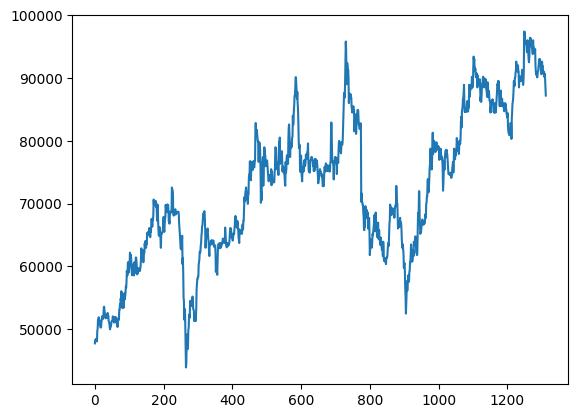

In [5]:
plt.plot(df1)

In [6]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [7]:
# 4. split the data into train and test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size 

train_data = df1[0:train_size,:]
test_data = df1[train_size:len(df1),:1]

In [8]:
#Training process
# a. convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

# b. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


In [9]:
print(X_train)

[[0.07180926 0.08043011 0.08329126 ... 0.18094437 0.16802244 0.16228144]
 [0.08043011 0.08329126 0.07899018 ... 0.16802244 0.16228144 0.15510051]
 [0.08329126 0.07899018 0.08473118 ... 0.16228144 0.15510051 0.14647966]
 ...
 [0.61475456 0.58784479 0.61950444 ... 0.57991585 0.60050491 0.6511828 ]
 [0.58784479 0.61950444 0.63218326 ... 0.60050491 0.6511828  0.6400935 ]
 [0.61950444 0.63218326 0.6400935  ... 0.6511828  0.6400935  0.63534362]]


In [10]:
# 8. Define GRU Model
model = xgb.XGBRegressor(
                        objective='reg:squarederror',
                        n_estimators=1000,
                        learning_rate=0.01,
                        max_depth=6,
                        subsample=0.8,
                        colsample_bytree=0.8)

In [11]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [12]:
# Dự báo dữ liệu test, val
y_pred=model.predict(X_test)

#  inverse transform the scaled ytest data back to its original scale.
y_pred = scaler.inverse_transform(y_pred.reshape(-1,1))
y_test = scaler.inverse_transform(y_test.reshape(-1,1))

In [13]:
#Dự đoán 30 ngày tiếp theo
x_input = test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output30 = []
n_steps = time_step
i = 0
pred_days = 30
while(i < pred_days):
    
    if(len(temp_input) > time_step):
        
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1,-1)
        
        yhat = model.predict(x_input)
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]
       
        lst_output30.extend(yhat.tolist())
        i = i+1
        
    else:
        yhat = model.predict(x_input)
        
        temp_input.extend(yhat.tolist())
        lst_output30.extend(yhat.tolist())
        
        i = i+1
        

In [14]:
#Dự đoán 60 ngày tiếp theo
x_input = test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output60 = []
n_steps = time_step
i = 0
pred_days = 60
while(i < pred_days):
    
    if(len(temp_input) > time_step):
        
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1,-1)
        
        yhat = model.predict(x_input)
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]
       
        lst_output60.extend(yhat.tolist())
        i = i+1
        
    else:
        yhat = model.predict(x_input)
        
        temp_input.extend(yhat.tolist())
        lst_output60.extend(yhat.tolist())
        
        i = i+1

In [15]:
#Dự đoán 90 ngày tiếp theo
x_input = test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output90 = []
n_steps = time_step
i = 0
pred_days = 90
while(i < pred_days):
    
    if(len(temp_input) > time_step):
        
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1,-1)
        
        yhat = model.predict(x_input)
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]
       
        lst_output90.extend(yhat.tolist())
        i = i+1
        
    else:
        yhat = model.predict(x_input)
        
        temp_input.extend(yhat.tolist())
        lst_output90.extend(yhat.tolist())
        
        i = i+1
        

In [16]:
# Convert the prediction lists to NumPy arrays and reshape them
lst_output90 = np.array(lst_output90).reshape(-1, 1)
lst_output60 = np.array(lst_output60).reshape(-1, 1)
lst_output30 = np.array(lst_output30).reshape(-1, 1)

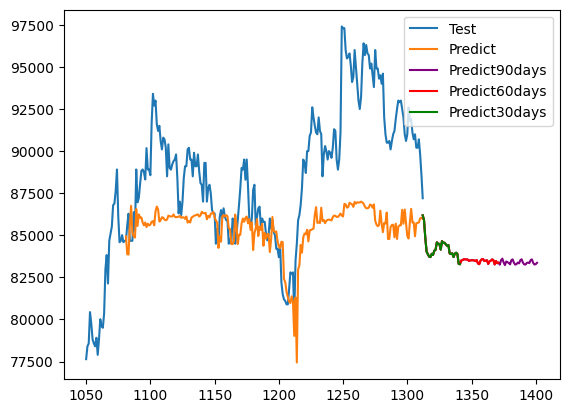

In [17]:


test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+time_step+1, stop=train_size+test_size, step=1)
plt.plot(test_data_index, (y_pred))

predict_data_index_90 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(predict_data_index_90,scaler.inverse_transform(lst_output90), color='purple')
predict_data_index_60 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(predict_data_index_60,scaler.inverse_transform(lst_output60), color='red')
predict_data_index_30 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(predict_data_index_30,scaler.inverse_transform(lst_output30), color='green')
plt.legend(['Test','Predict','Predict90days', 'Predict60days', 'Predict30days'])

plt.show()

In [18]:
# 12. Đánh giá độ chính xác thuật toán 
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Testing RMSE:', test_rmse)

from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
print('Testing MAE:', test_mae)

from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(y_test, y_pred)
print('Testing MAPE:', test_mape)  

Testing RMSE: 4671.164866189771
Testing MAE: 3751.232455549569
Testing MAPE: 0.040999673719937624
